### **[강화 학습] Reinforcement Learning - Assignment #3**
# **Q-Learning Control in Blackjack Environment**

**(마감일: 2020년 11월 30일 오전 12:00시) - (2019 55718 - MELIA PUTRI H)**

### **Gym Libraries**
> Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

In [20]:
import gym
from gym import spaces
from gym.utils import seeding

### **BlackJack Environment**

In [21]:
def cmp(a,b):
  return float(a>b)-float(a<b)

In [22]:
#1=Ace, 2-10=Number Cards, Jack/Queen/King=10
deck=[1,2,3,4,5,6,7,8,9,10,10,10,10]

In [23]:
def draw_card(np_random):
  return int(np_random.choice(deck))

In [24]:
def draw_hand(np_random):
  return [draw_card(np_random),draw_card(np_random)]

In [25]:
#Does this hand have a usable Ace card?
def usable_ace(hand):
  return 1 in hand and sum(hand)+10<=21

In [26]:
#Return the current hand total
def sum_hand(hand):
  if usable_ace(hand):
    return sum(hand)+10
  return sum(hand)

In [27]:
#Is this hand a bust?
def is_bust(hand):
  return sum_hand(hand)>21

In [28]:
#What is the score of this hand (0 if bust)?
def score(hand):
  return 0 if is_bust(hand) else sum_hand(hand)

In [29]:
#Is this hand a natural Black Jack? (21)
def is_natural(hand):
  return sorted(hand)==[1,10] #Cards are an Ace and a 10, Jack, Queen, or King

In [30]:
class BlackJackEnv(gym.Env):
  def __init__(self,natural=False):
    self.action_space=spaces.Discrete(2)
    self.observation_space=spaces.Tuple((spaces.Discrete(32),
                                         spaces.Discrete(11),
                                         spaces.Discrete(2)))
    self.seed()

    #Flag to payout 1.5 on a "natural" Black Jack Win, like casino rules
    self.natural=natural

    #Start the First Game
    self.reset()

  def seed(self,seed=None):
    self.np_random,seed=seeding.np_random(seed)
    return [seed]
  
  def step(self,action):
    assert self.action_space.contains(action)
    #HIT: Add a card to players hand and return
    if action:
      self.player.append(draw_card(self.np_random))
      if is_bust(self.player):
        done=True
        reward=-1.
      else:
        done=False
        reward=0.
    #STICK: Play out the dealers hand, and score
    else:
      done=True
      while sum_hand(self.dealer)<17:
        self.dealer.append(draw_card(self.np_random))
      reward=cmp(score(self.player),score(self.dealer))
      if self.natural and is_natural(self.player) and reward==1.:
        reward=1.5
    return self._get_obs(),reward,done,{}
  
  def _get_obs(self):
    return(sum_hand(self.player),self.dealer[0],usable_ace(self.player))
  
  def reset(self):
    self.dealer=draw_hand(self.np_random)
    self.player=draw_hand(self.np_random)
    return self._get_obs()

### **BlackJack with Q-Learning Control**

With Q-learning target:

$R_{t+1}+𝛾Q(S_{t+1},A')$
$=R_{t+1}+𝛾Q(S_{t+1},\underset{a'}{\operatorname{argmax}}Q(S_{t+1},a')$
$=R_{t+1}+\underset{a'}{\operatorname{max}}𝛾Q(S_{t+1},a')$

In [31]:
#import env_blackjack 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [32]:
env=BlackJackEnv()
Q=np.zeros((2,10,10,2)) #Initialize Q(s,a)
N=np.zeros((2,10,10,2)) #Number of Visits
gamma=1                 #Discount Factor  

In [33]:
num_episodes=64000000

In [34]:
def state_idx(state):
  return state[2]*1,state[0]-12,state[1]-1

In [35]:
def policy(stats,k):
  episode=10000/(k+10000)
  if np.random.rand()<episode:
    action=np.random.randint(0,2)
  else:
    action=np.argmax(Q[state_idx(state)])
  return action

In [38]:
winning_counter=0
for episode in range(num_episodes):
  state=env.reset()
  done=False
  while state[0]<12:
    state,_,done,_=env.step(1)
  
  while done==False:
    action=policy(state,episode)
    next_state,reward,done,_=env.step(action)
    index=(*state_idx(state),action)
    N[index]+=1
    if done == False: #As the episode goes by
      #Q-Learning Target
      Q[index]+=(reward+gamma*np.max(Q[(state_idx(next_state))])-Q[index])/N[index]
    else:
      Q[index]+=(reward-Q[index])/N[index]
    state=next_state
  winning_counter+=(reward>0)*1.0

  if (episode+1)%10000==0:
    print("Episode: %6d, Winning rate: %.2f"%(episode+1,winning_counter/(episode+1)))

Qmax=np.max(Q,axis=3) 
optimalaction=np.argmax(Q,axis=3)
print(Qmax)
print(optimalaction)

Streaming output truncated to the last 5000 lines.
Episode: 14830000, Winning rate: 0.43
Episode: 14840000, Winning rate: 0.43
Episode: 14850000, Winning rate: 0.43
Episode: 14860000, Winning rate: 0.43
Episode: 14870000, Winning rate: 0.43
Episode: 14880000, Winning rate: 0.43
Episode: 14890000, Winning rate: 0.43
Episode: 14900000, Winning rate: 0.43
Episode: 14910000, Winning rate: 0.43
Episode: 14920000, Winning rate: 0.43
Episode: 14930000, Winning rate: 0.43
Episode: 14940000, Winning rate: 0.43
Episode: 14950000, Winning rate: 0.43
Episode: 14960000, Winning rate: 0.43
Episode: 14970000, Winning rate: 0.43
Episode: 14980000, Winning rate: 0.43
Episode: 14990000, Winning rate: 0.43
Episode: 15000000, Winning rate: 0.43
Episode: 15010000, Winning rate: 0.43
Episode: 15020000, Winning rate: 0.43
Episode: 15030000, Winning rate: 0.43
Episode: 15040000, Winning rate: 0.43
Episode: 15050000, Winning rate: 0.43
Episode: 15060000, Winning rate: 0.43
Episode: 15070000, Winning rate: 0.43

Text(0.5, 1.0, 'Usable ace')

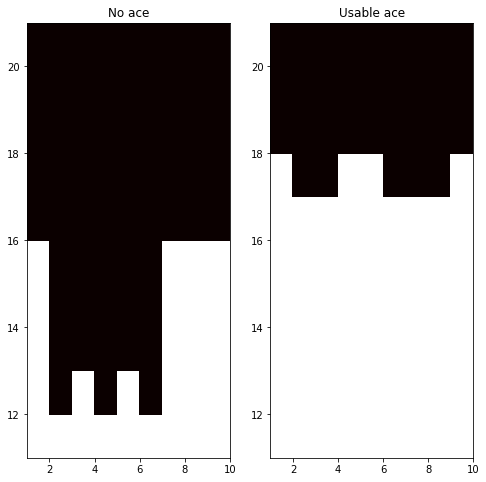

In [47]:
fig1=plt.figure(figsize=(8,8),facecolor='w')
ax1=fig1.add_subplot(1,2,1)
ax1.pcolormesh(np.arange(1,11),np.arange(11,22),action_opt[0],cmap='hot')
ax1.set_title('No ace')
ax2=fig1.add_subplot(1,2,2)
ax2.pcolormesh(np.arange(1,11),np.arange(11,22),action_opt[1],cmap='hot')
ax2.set_title('Usable ace')

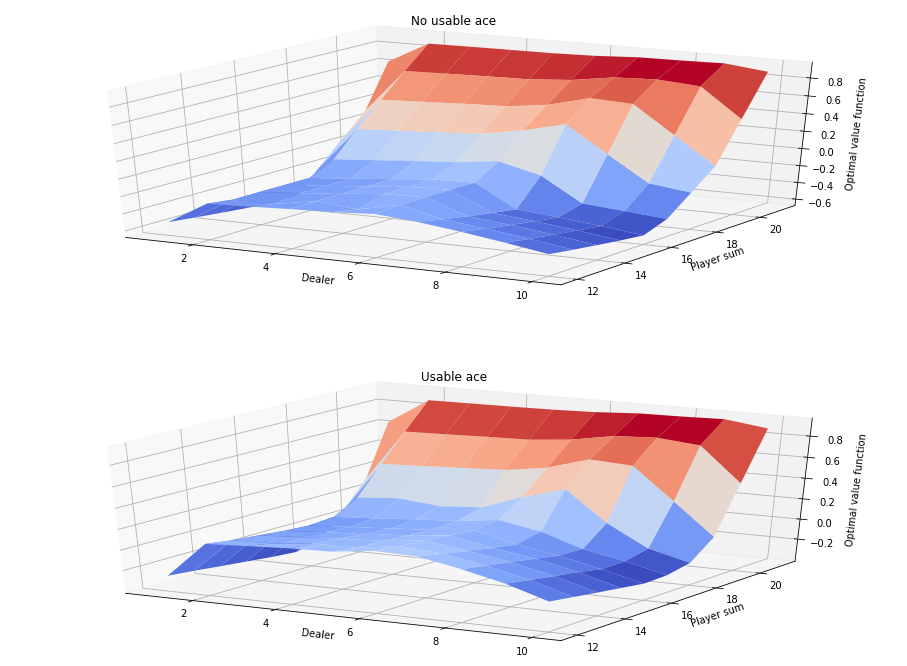

In [43]:
#Results Visualization
X=np.arange(1,11)
Y=np.arange(12,22)
X,Y=np.meshgrid(X, Y)

fig2=plt.figure(figsize=(16,12),facecolor='w')

ax0=fig2.add_subplot(211,projection='3d')
ax0.plot_surface(X,Y,Q_max[0],rstride=1,cstride=1,cmap='coolwarm') 
ax0.set_xlabel('Dealer')
ax0.set_ylabel('Player sum')
ax0.set_zlabel('Optimal value function')
ax0.set_title('No usable ace')

ax1=fig2.add_subplot(212,projection='3d')
ax1.plot_surface(X,Y,Q_max[1],rstride=1,cstride=1,cmap='coolwarm') 
ax1.set_xlabel('Dealer')
ax1.set_ylabel('Player sum')
ax1.set_zlabel('Optimal value function')
ax1.set_title('Usable ace')
plt.show()